## Training Mask R-CNN on a Ghosting artifacts dataset

In this notebook we use the matterport implementation (https://github.com/matterport/Mask_RCNN) of Mask R-CNN (https://arxiv.org/abs/1703.06870), an object instance segmentation algorithm developed by FAIR (Facebook AI Research), and train in on a manually annotated dataset of ghosting artifacts found in DES images.


In [1]:
# Import basic packages 
import numpy as np 
import scipy as scipy 
import os
import sys
import json
import datetime
import skimage.draw
import cv2
from imgaug import augmenters as iaa # For image augmentation

#import tensorflow 1
%tensorflow_version 1.x
import keras

# Colab in order to be able to download files
from google.colab import files

# Matplotlib plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

TensorFlow 1.x selected.


Using TensorFlow backend.


Un-comment and run the following lines in order to install packages that 
allow LaTeX to be used in matplotlib (process of labels).

In [3]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super

In [4]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/
#!pwd
!pip install fitsio

/content/drive/MyDrive
     |████████████████████████████████| 5.0MB 6.4MB/s 
  Created wheel for fitsio: filename=fitsio-1.1.4-cp37-cp37m-linux_x86_64.whl size=1778725 sha256=6bfdc021023339e79f4acb580b168093b5a61d6761f21a0f55aece62e861849f
  Stored in directory: /root/.cache/pip/wheels/22/41/8e/36c7c16edc7fd0ecc4aa3064c565d1b62152f2ff58ac567266
Successfully built fitsio


**Import Mask R-CNN**

In [6]:
# To find the path for Mask_RCNN
sys.path.insert(1, 'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Useful directory paths paths,
these are to save the logs of the trained model and to find the 
weights of the "Coco" that are used for transfer learning.

In [7]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [8]:
# Notebook preferences
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Configurations

Here we create a class that overrides some of the Mask R-CNN model configurations we have to change. 

Some of them are basic and no further experimentation can be done, like the number of classes we have, while for other parameters we can try different values in order to find the optimal ones (such as the learning rate).



In [9]:
# This class can be further edited

class GhostsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Type"
 
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + three ghost categories

    # Learning rate - DEFAULT = 0.004
    LEARNING_RATE = 0.004

    # How to resize the image
    # Use "none" if you don't want to resize
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Maximum number of ground truth instances (objects) in one image
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100

 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 150
 
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

config = GhostsConfig()

# Uncomment the following line, if you want to see the values of all the 
# configuration parameters (including the default values)
#config.display() 

### Load training-validation datasets

The following class loads the images and the annotations (masks) for the training and validation sets.

In [10]:
class GhostsDataset(utils.Dataset):
 
    def load_ghosts(self, dataset_dir, subset):
        """Load a subset of the ghosts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have three classes to add.
        self.add_class("Type", 1, "Bright")
        self.add_class("Type", 2, "Faint")
        self.add_class("Type", 3, "Rays")
 
        # Train or validation dataset?
        assert subset in ["Training_set", "Validation_set"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        # Load annotations - in the format of VGC annotator
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
      
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images (in principle there shouldn't be any):
        annotations = [a for a in annotations if a['regions']]


        # Add images
        for a in annotations:
          
            # Get the  coordinates of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['Type'] for s in a['regions']]
            #print("objects:",objects)
            name_dict = {"Bright": 1,"Faint": 2,"Rays":3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
 
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. 
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)#/255.0   #It's not necessary 
            height, width = image.shape[:2]
 
            self.add_image(
                "Type",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "Type":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        #print(info["source"])
        if info["source"] != "Type":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
      
        for i, p in enumerate(info["polygons"]):
            name = p['name']
            # Now, we can have different types of shapes
            if (name=='polyline'):
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
              a = (rr<400)&(cc<400)
              mask[rr[a], cc[a], i] = 1
            elif (name=='polygon'):
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
              a = (rr<400)&(cc<400)
              mask[rr[a], cc[a], i] = 1
            elif (name=='rect'):
              rr, cc = skimage.draw.rectangle(start=(p['y'], p['x']),extent=(p['height'],p['width']))
              a = (rr<400)&(cc<400)
              mask[rr[a], cc[a], i] = 1
            elif (name=='circle'):
              rr, cc = skimage.draw.circle(p['cy'],p['cx'],p['r'])
              a = (rr<400)&(cc<400)
              mask[rr[a], cc[a], i] = 1
            elif (name=='ellipse'): 
              rr, cc = skimage.draw.ellipse(p['cy'],p['cx'],p['ry'],p['rx'],shape=None,rotation=-p['theta'])
              a = (rr<400)&(cc<400)
              mask[rr[a], cc[a], i] = 1
            
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Type":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

Now load the datasets

In [11]:
#Give the path to the Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "MyDrive/Dataset")

# Training dataset.
dataset_train = GhostsDataset()
dataset_train.load_ghosts(DATASET_DIR, "Training_set")
dataset_train.prepare()

# Validation dataset
dataset_val = GhostsDataset()
dataset_val.load_ghosts(DATASET_DIR, "Validation_set")
dataset_val.prepare()

# Image Augmentation
# Note: we can add more here
augmentation = iaa.SomeOf((0, 3),[
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.Affine(rotate=270)])

**Load and display random samples**

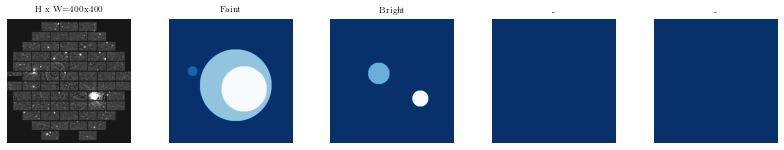

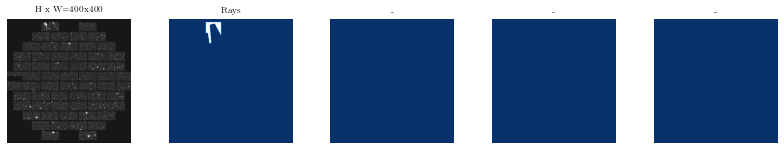

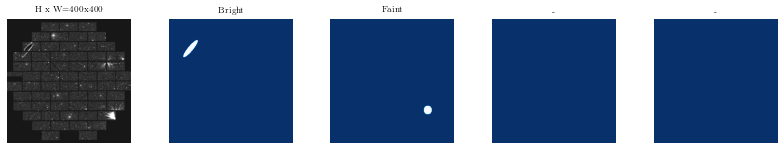

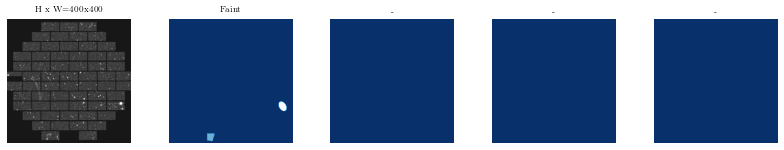

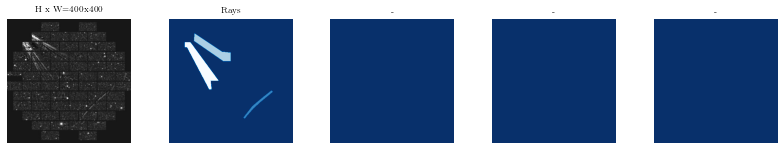

In [12]:
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    #print(np.shape(image))
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Mask R-CNN model

Now we create a Mask R-CNN model in training mode. We use *transfer learning* with the COCO weights.

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
# Here we use coco, but one can try imagenet

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# ===========================================================
# ===========================================================   
# In case we want to pause and continue, this can be used
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Now we can actually train our model. 

We train in multiple steps.

- First only the top, "heads", layers with a learning rate $\alpha = 4 \times 10^{-3}$ for 15 eponchs

- Then all layers with a learning rate $\alpha = 4 \times 10^{-4}$ for 20 epochs

- Then all layers with a learning rate $\alpha = 4 \times 10^{-5}$ for 20 epochs

- Then all layers with a learning rate $\alpha = 4 \times 10^{-6}$ for 20 epochs

In [15]:
# Train "heads" for 15 epochs
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            augmentation=augmentation,
            epochs=15, 
            layers='heads')

#Get History dictionary for this first part
history_dict_1 = model.keras_model.history.history


Starting at epoch 0. LR=0.004

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/type20210504T2000/mask_rcnn_type_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/15
150/150 [==============================] - 118s 790ms/step - loss: 2.0388 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.4561 - mrcnn_class_loss: 0.4018 - mrcnn_bbox_loss: 0.5849 - mrcnn_mask_loss: 0.5189 - val_loss: 2.9903 - val_rpn_class_loss: 0.0766 - val_rpn_bbox_loss: 0.6219 - val_mrcnn_class_loss: 0.4651 - val_mrcnn_bbox_loss: 0.6676 - val_mrcnn_mask_loss: 0.4978

Epoch 2/15
150/150 [==============================] - 92s 615ms/step - loss: 1.7990 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.5027 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.4445 - mrcnn_mask_loss: 0.4563 - val_loss: 2.0520 - val_rpn_class_loss: 0.0833 - val_rpn_bbox_loss: 0.7163 - val_mrcnn_class_loss: 0.4150 - val_mrcnn_bbox_loss: 0.4786 - val_mrcnn_mask_loss: 0.4947
Epoch 3/15
150/150 [==============================] - 92s 614ms/step - loss: 1.5989 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.4132 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.4383 - val_loss: 2.3968 - val_rpn

In [16]:
# Fine tune all layers for 20 epochs
# With smaller training rate
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            augmentation=augmentation,
            epochs=35, 
            layers="all")

#Get History dictionary for the second part
history_dict_2 = model.keras_model.history.history


Starting at epoch 15. LR=0.0004

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/type20210504T2000/mask_rcnn_type_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 16/35
150/150 [==============================] - 166s 1s/step - loss: 1.4193 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.3855 - val_loss: 1.8053 - val_rpn_class_loss: 0.0671 - val_rpn_bbox_loss: 0.5955 - val_mrcnn_class_loss: 0.3087 - val_mrcnn_bbox_loss: 0.3350 - val_mrcnn_mask_loss: 0.4037
Epoch 17/35
150/150 [==============================] - 139s 925ms/step - loss: 1.3794 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.3787 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.3770 - val_loss: 1.2072 - val_rpn_class_loss: 0.0637 - val_rpn_bbox_loss: 0.5558 - val_mrcnn_class_loss: 0.2245 - val_mrcnn_bbox_loss: 0.3371 - val_mrcnn_mask_loss: 0.4310
Epoch 18/35
150/150 [==============================] - 139s 927ms/step - loss: 1.2652 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.3477 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.3668 - val_loss: 1.2379 - val_rp

In [17]:
# Continue training with an even smaller learning rate
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/100,
            augmentation=augmentation,
            epochs=55, 
            layers="all")

#Get History for the third part
history_dict_3 = model.keras_model.history.history


Starting at epoch 35. LR=4e-05

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/type20210504T2000/mask_rcnn_type_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 36/55
150/150 [==============================] - 166s 1s/step - loss: 1.1629 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.3310 - val_loss: 1.2177 - val_rpn_class_loss: 0.0210 - val_rpn_bbox_loss: 0.3529 - val_mrcnn_class_loss: 0.2114 - val_mrcnn_bbox_loss: 0.2660 - val_mrcnn_mask_loss: 0.3589
Epoch 37/55
150/150 [==============================] - 140s 930ms/step - loss: 1.1683 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.3781 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.3231 - val_loss: 0.9546 - val_rpn_class_loss: 0.0401 - val_rpn_bbox_loss: 0.4416 - val_mrcnn_class_loss: 0.1841 - val_mrcnn_bbox_loss: 0.2694 - val_mrcnn_mask_loss: 0.3877
Epoch 38/55
150/150 [==============================] - 140s 930ms/step - loss: 1.1217 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.3142 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3322 - val_loss: 1.9345 - val_rp

In [18]:
# Final training/fine tuning with an even smaller learning rate
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/1000,
            augmentation=augmentation,
            epochs=75, 
            layers="all")

#Get History for the final part
history_dict_4 = model.keras_model.history.history


Starting at epoch 55. LR=4e-06

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/type20210504T2000/mask_rcnn_type_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 56/75
150/150 [==============================] - 168s 1s/step - loss: 1.1060 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3603 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.3324 - val_loss: 1.2842 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.3357 - val_mrcnn_class_loss: 0.1987 - val_mrcnn_bbox_loss: 0.2558 - val_mrcnn_mask_loss: 0.3524
Epoch 57/75
150/150 [==============================] - 140s 934ms/step - loss: 1.1053 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.3434 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.3154 - val_loss: 1.1589 - val_rpn_class_loss: 0.0433 - val_rpn_bbox_loss: 0.4800 - val_mrcnn_class_loss: 0.1646 - val_mrcnn_bbox_loss: 0.2849 - val_mrcnn_mask_loss: 0.4035
Epoch 58/75
150/150 [==============================] - 140s 932ms/step - loss: 1.0897 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.3251 - val_loss: 1.7322 - val_rp

## Training History

Now we get training history curves (training and validation losses as a function of epoch).

Mask R-CNN has different losses:


- RPN class loss (`rpn_class_loss`):

- RPN bounding box loss (`rpn_bbox_loss`):

- Mask R-CNN class loss (`mrcnn_class_loss`):

- Mask R-CNN bounding box loss (`mrcnn_bbox_loss`):

- Mask R-CNN mask loss (`mrcnn_mask_loss`): 


And, of course, the total loss, which is the sum of the above losses.


In [19]:
# Get losses for the first part

# Training
loss_1 = history_dict_1['loss']
rpn_class_loss_1 = history_dict_1['rpn_class_loss']
rpn_bbox_loss_1 = history_dict_1['rpn_bbox_loss']
mrcnn_class_loss_1 = history_dict_1['mrcnn_class_loss']
mrcnn_bbox_loss_1 = history_dict_1['mrcnn_bbox_loss']
mrcnn_mask_loss_1 = history_dict_1['mrcnn_mask_loss']
# ============================================================
# ============================================================
# Validation
val_loss_1 = history_dict_1['val_loss']
val_rpn_class_loss_1 = history_dict_1['val_rpn_class_loss']
val_rpn_bbox_loss_1 = history_dict_1['val_rpn_bbox_loss']
val_mrcnn_class_loss_1 = history_dict_1['val_mrcnn_class_loss']
val_mrcnn_bbox_loss_1 = history_dict_1['val_mrcnn_bbox_loss']
val_mrcnn_mask_loss_1 = history_dict_1['val_mrcnn_mask_loss']

In [21]:
# Get losses for the second part

# Training
loss_2 = history_dict_2['loss']
rpn_class_loss_2 = history_dict_2['rpn_class_loss']
rpn_bbox_loss_2 = history_dict_2['rpn_bbox_loss']
mrcnn_class_loss_2 = history_dict_2['mrcnn_class_loss']
mrcnn_bbox_loss_2 = history_dict_2['mrcnn_bbox_loss']
mrcnn_mask_loss_2 = history_dict_2['mrcnn_mask_loss']
# ============================================================
# ============================================================
# Validation
val_loss_2 = history_dict_2['val_loss']
val_rpn_class_loss_2 = history_dict_2['val_rpn_class_loss']
val_rpn_bbox_loss_2 = history_dict_2['val_rpn_bbox_loss']
val_mrcnn_class_loss_2 = history_dict_2['val_mrcnn_class_loss']
val_mrcnn_bbox_loss_2 = history_dict_2['val_mrcnn_bbox_loss']
val_mrcnn_mask_loss_2 = history_dict_2['val_mrcnn_mask_loss']

In [22]:
# Get losses for the third part

# Training
loss_3 = history_dict_3['loss']
rpn_class_loss_3 = history_dict_3['rpn_class_loss']
rpn_bbox_loss_3 = history_dict_3['rpn_bbox_loss']
mrcnn_class_loss_3 = history_dict_3['mrcnn_class_loss']
mrcnn_bbox_loss_3 = history_dict_3['mrcnn_bbox_loss']
mrcnn_mask_loss_3 = history_dict_3['mrcnn_mask_loss']
# ============================================================
# ============================================================
# Validation
val_loss_3 = history_dict_3['val_loss']
val_rpn_class_loss_3 = history_dict_3['val_rpn_class_loss']
val_rpn_bbox_loss_3 = history_dict_3['val_rpn_bbox_loss']
val_mrcnn_class_loss_3 = history_dict_3['val_mrcnn_class_loss']
val_mrcnn_bbox_loss_3 = history_dict_3['val_mrcnn_bbox_loss']
val_mrcnn_mask_loss_3 = history_dict_3['val_mrcnn_mask_loss']

In [24]:
# Get losses for the last part

# Training
loss_4 = history_dict_4['loss']
rpn_class_loss_4 = history_dict_4['rpn_class_loss']
rpn_bbox_loss_4 = history_dict_4['rpn_bbox_loss']
mrcnn_class_loss_4 = history_dict_4['mrcnn_class_loss']
mrcnn_bbox_loss_4 = history_dict_4['mrcnn_bbox_loss']
mrcnn_mask_loss_4 = history_dict_4['mrcnn_mask_loss']
# ============================================================
# ============================================================
# Validation
val_loss_4 = history_dict_4['val_loss']
val_rpn_class_loss_4 = history_dict_4['val_rpn_class_loss']
val_rpn_bbox_loss_4 = history_dict_4['val_rpn_bbox_loss']
val_mrcnn_class_loss_4 = history_dict_4['val_mrcnn_class_loss']
val_mrcnn_bbox_loss_4 = history_dict_4['val_mrcnn_bbox_loss']
val_mrcnn_mask_loss_4 = history_dict_4['val_mrcnn_mask_loss']

Now concatenate the arrays

In [25]:
# Training
loss = np.concatenate((loss_1,loss_2,loss_3,loss_4))
rpn_class_loss = np.concatenate((rpn_class_loss_1,rpn_class_loss_2,rpn_class_loss_3,rpn_class_loss_4))
rpn_bbox_loss = np.concatenate((rpn_bbox_loss_1,rpn_bbox_loss_2,rpn_bbox_loss_3,rpn_bbox_loss_4))
mrcnn_class_loss = np.concatenate((mrcnn_class_loss_1,mrcnn_class_loss_2,mrcnn_class_loss_3,mrcnn_class_loss_4))
mrcnn_bbox_loss = np.concatenate((mrcnn_bbox_loss_1,mrcnn_bbox_loss_2,mrcnn_bbox_loss_3,mrcnn_bbox_loss_4))
mrcnn_mask_loss = np.concatenate((mrcnn_mask_loss_1,mrcnn_mask_loss_2,mrcnn_mask_loss_3,mrcnn_mask_loss_4))
# =============================================================
# Validation
val_loss = np.concatenate((val_loss_1,val_loss_2,val_loss_3,val_loss_4))
val_rpn_class_loss = np.concatenate((val_rpn_class_loss_1,val_rpn_class_loss_2,
                                     val_rpn_class_loss_3,val_rpn_class_loss_4))
val_rpn_bbox_loss = np.concatenate((val_rpn_bbox_loss_1,val_rpn_bbox_loss_2,
                                    val_rpn_bbox_loss_3,val_rpn_bbox_loss_4))
val_mrcnn_class_loss = np.concatenate((val_mrcnn_class_loss_1,val_mrcnn_class_loss_2,
                                       val_mrcnn_class_loss_3,val_mrcnn_class_loss_4))
val_mrcnn_bbox_loss = np.concatenate((val_mrcnn_bbox_loss_1,val_mrcnn_bbox_loss_2,
                                      val_mrcnn_bbox_loss_3,val_mrcnn_bbox_loss_4))
val_mrcnn_mask_loss = np.concatenate((val_mrcnn_mask_loss_1,val_mrcnn_mask_loss_2,
                                      val_mrcnn_mask_loss_3,val_mrcnn_mask_loss_4))

### Make Plots

Now make plots of the histrory (loss vs epoch) for the five different types of loss we have for Mask R-CNN.

In [54]:
# Number of Epochs to train
Epochs = np.arange(1,76,1)

# Defines proportions
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

- Total loss

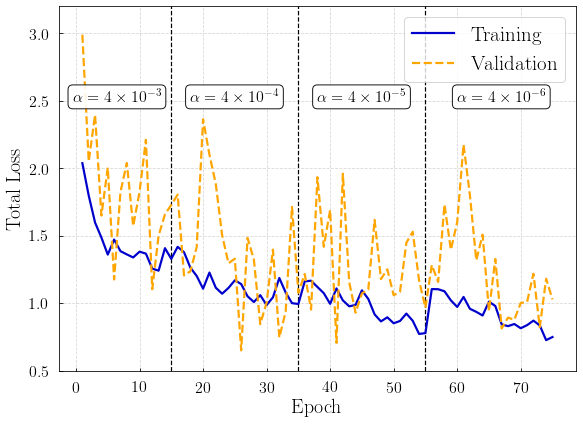

In [64]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,0.5,3.2, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,0.5,3.2, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,0.5,3.2, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,2.5, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,2.5, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,2.5, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,2.5, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('Total Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)

plt.ylim(0.5,3.2)

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Total_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/Total_Loss.pdf")
plt.show()

- RPN classification loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

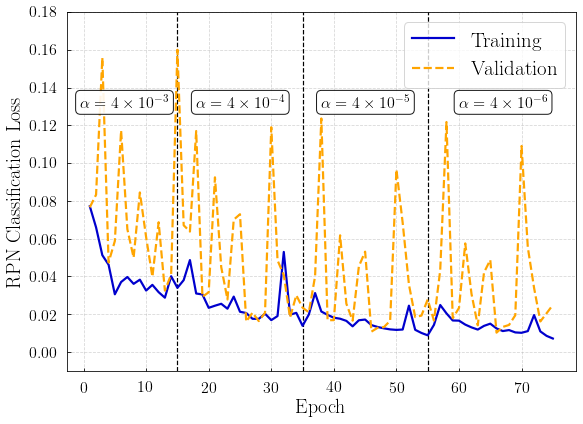

In [74]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,rpn_class_loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_rpn_class_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,-0.01,0.18, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,-0.01,0.18, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,-0.01,0.18, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,0.13, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,0.13, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,0.13, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,0.13, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('RPN Classification Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.yticks(np.arange(0, 0.20, 0.02))

plt.ylim(-0.01,0.18)

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/RPN_Class_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/RPN_Class_Loss.pdf")
plt.show()


- RNP bounding box loss



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

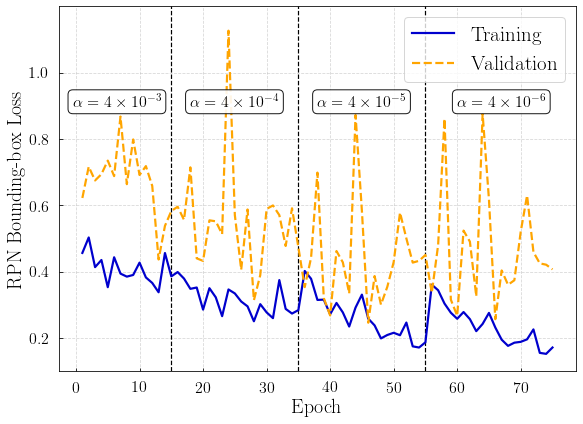

In [81]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,rpn_bbox_loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_rpn_bbox_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,0.1,1.2, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,0.1,1.2, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,0.1,1.2, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,0.9, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,0.9, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,0.9, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,0.9, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('RPN Bounding-box Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.yticks(np.arange(0.2, 1.2, 0.2))

plt.ylim(0.1,1.2)

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/RPN_bbox_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/RPN_bbox_Loss.pdf")
plt.show()

- Mask R-CNN Classification Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

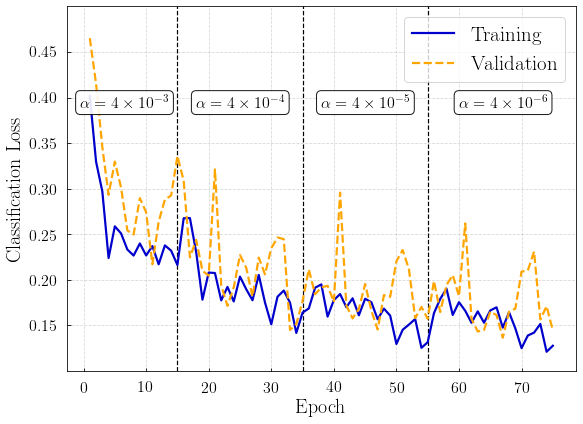

In [88]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,mrcnn_class_loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_mrcnn_class_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,0.1,0.5, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,0.1,0.5, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,0.1,0.5, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,0.39, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,0.39, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,0.39, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,0.39, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('Classification Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.yticks(np.arange(0.15, 0.45, 0.05))

plt.ylim(0.1,0.5)

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Classification_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/Classification_Loss.pdf")
plt.show()


- Bounding-box Loss



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

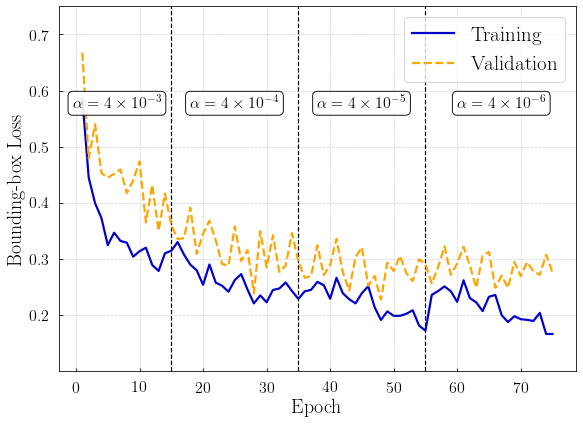

In [95]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,mrcnn_bbox_loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_mrcnn_bbox_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,0.1,0.75, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,0.1,0.75, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,0.1,0.75, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,0.57, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,0.57, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,0.57, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,0.57, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('Bounding-box Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.yticks(np.arange(0.2, 0.8, 0.1))

plt.ylim(0.1,0.75)

plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Bounding_box_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/Bounding_box_Loss.pdf")
plt.show()

- Mask Loss



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

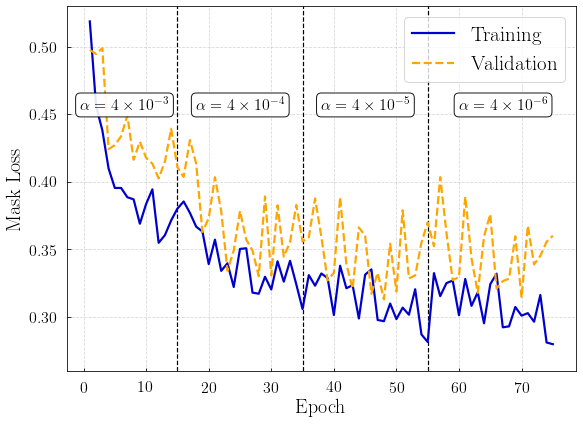

In [103]:
plt.figure(figsize=(8.2, 6.0))

#Basic Plotting
plt.plot(Epochs,mrcnn_mask_loss,c = 'mediumblue',linewidth=2.2,label='Training')
plt.plot(Epochs,val_mrcnn_mask_loss,c = 'orange',linewidth=2.2, ls='--', label='Validation')

#Vertical lines
plt.vlines(15,0.26,0.53, color='k', linewidth=1.2,linestyle='--')
plt.vlines(35,0.26,0.53, color='k', linewidth=1.2,linestyle='--')
plt.vlines(55,0.26,0.53, color='k', linewidth=1.2,linestyle='--')

#Text boxes with the learning rates in each region
plt.text(-0.5,0.454, r'$\alpha=4 \times 10^{-3}$',bbox=props, color='k',fontsize=16)
plt.text(18,0.454, r'$\alpha=4 \times 10^{-4}$',bbox=props, color='k',fontsize=16)
plt.text(38,0.454, r'$\alpha=4 \times 10^{-5}$',bbox=props, color='k',fontsize=16)
plt.text(60,0.454, r'$\alpha=4 \times 10^{-6}$',bbox=props, color='k',fontsize=16)

# Legends/labels etc
plt.legend(frameon=True, loc='upper right', fontsize=21)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('Mask Loss',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.yticks(np.arange(0.3, 0.55, 0.05))

plt.ylim(0.26,0.53)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Mask_Loss.pdf")
files.download("/content/drive/My Drive/Plots/Mask_Loss.pdf")
plt.show()

Save the dictionaries as pickle files

In [111]:
!pwd

/content/drive/My Drive


In [112]:
import pickle

f = open("history_dict_1","wb")
pickle.dump(history_dict_1,f)
f.close()
# ==========================
f = open("history_dict_2","wb")
pickle.dump(history_dict_2,f)
f.close()
# ===========================
f = open("history_dict_3","wb")
pickle.dump(history_dict_3,f)
f.close()
# ===========================
f = open("history_dict_4","wb")
pickle.dump(history_dict_4,f)
f.close()